In [6]:
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

-----
# Exercise 1

# (a)
We have the table of data in the next cell.

Using `numpy.linalg.lstsq()`, fit a straight line, a quadratic function, and a cubic function to these data. Plot the data and your fitted functions in a graph. It is **not** allowed to use numpy.polyfit, but you may have a look at the documentation to see some examples.

In [7]:
t = np.array([3, 11, 29, 32, 47, 63, 73, 99])
w = np.array([74, 72, 52, 35, 37, 20, 19, 19])

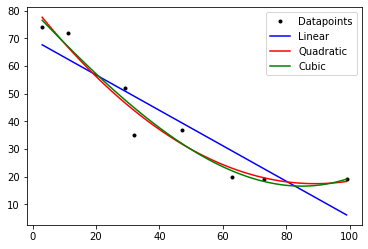

A residual of 599.666 was found with the straight line fit.
A residual of 181.77 was found with the quadratic function fit.
A residual of 174.967 was found with the cubic function fit.


In [16]:
M = np.vstack([t, np.ones(len(t))]).T
A = np.vstack([t**2,t,np.ones(len(t))]).T
Q = np.vstack([t**3,t**2,t,np.ones(len(t))]).T

a, b = np.linalg.lstsq(M, w, rcond=None)[0]
c,d,e = np.linalg.lstsq(A,w,rcond=None)[0]
f,g,h,i = np.linalg.lstsq(Q,w,rcond=None)[0]

smaller_t = np.linspace(t[0],t[-1],100)

plt.plot(t,w,'ko',markersize=3,label='Datapoints')
plt.plot(smaller_t,a*smaller_t+b,'b-',label='Linear')
plt.plot(smaller_t,c*smaller_t**2+d*smaller_t+e,'r-',label='Quadratic')
plt.plot(smaller_t,f*smaller_t**3+g*smaller_t**2+h*smaller_t+i,'g-', label='Cubic')
plt.legend()
plt.show()

print(f"A residual of {round(np.sum((w-(a*t + b))**2),3)} was found with the straight line fit.")
print(f"A residual of {round(np.sum((w-(c*t**2+d*t+e))**2),3)} was found with the quadratic function fit.")
print(f"A residual of {round(np.sum((w-(f*t**3+g*t**2+h*t+i))**2),3)} was found with the cubic function fit.")

-----
# Exercise 2
We want to reconstruct a function $s(t)$ (also called the signal in this exercise), $t \in [0,1]$, from data given by
$$d(t) = \int_0^1 s(t) \, dt + \text{noise}.$$
We assume the data is given at $n$ equally space time points $t_j = j h$, $h = \frac{1}{n}$, $j=1,2, \ldots, n$. The data is therefore a vector $d = [d_1, \ldots, d_n]$, where $d_j$ denotes the value at $t_j$. 
The signal $s$ is to be reconstructed at time points 
$t_{j-1/2} = (j-1/2)h$ for $j = 1,2, \ldots, n$. It is described by a vector $s = [s_1, \ldots, s_n]$ with $s_j$ the value at $t_{j-1/2}$.
Numerical integration is described in Chapter 8 of the book by Heath. Using the composite midpoint rule, the vectors $s$ and $d$ are related by
$$d = A \cdot s + \text{noise}$$
where
$$A = \begin{bmatrix} 
h & 0 & 0 & \ldots & 0 \\
h & h & 0 & \ldots & 0 \\
h & h & h & \ddots &  \vdots \\
\vdots & \vdots & \ddots & \ddots & 0 \\
h & h & \ldots & h  & h 
\end{bmatrix}.$$


## (a)
As a test signal we take
$$s_{\rm true}(t) = \left\{
\begin{array}{ll} 1 & \text{if $|t-1/2|<0.15$}\\
0 & \text{otherwise} \end{array} 
\right. .$$ 
Generate data $d_0$ without noise and data $d_\epsilon$ with noise, where the noise is normally distributed, with mean zero and standard deviation $\epsilon = 0.005$.
Take for example $n=100$. Plot the data.

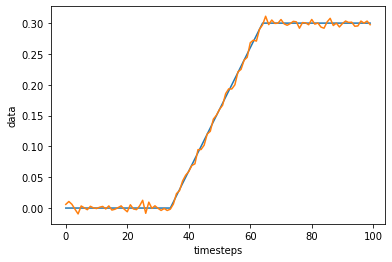

In [17]:
def signal(t): 
    return np.where(np.abs(t - 1/2)<0.15, 1, 0)

def data(s, n, noise_on=True):
    h = 1/n
    A = np.tril(h*np.ones((n,n)))
    
    noise = np.zeros(n)
    if noise_on:
        noise = np.random.normal(0, 0.005, n)
    
    return A.dot(s) + noise
        
n = 100
t = np.arange(0,1,1/n)

s = signal(t)

d_0 = data(s,n,False)
d_e = data(s,n)

plt.figure()
plt.plot(d_0)
plt.plot(d_e)
plt.xlabel("timesteps")
plt.ylabel("data")
plt.show()

## (b)
Try to determine $s$ from $d_0$ by inverting the matrix $A$, ignoring the noise term.
Do the same with $d_\epsilon$ instead of $d_0$. Plot the results. What do you observe about the errors in the inversion?

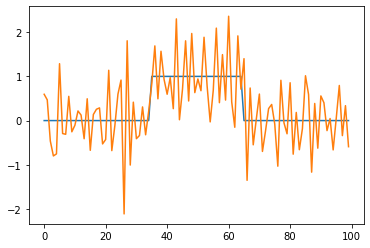

In [18]:
h = 1/n
A = np.tril(h*np.ones((n,n)))
A_inv = np.linalg.inv(A)
noise = np.random.normal(0, 0.005, n)

s_0 = A_inv.dot(d_0)
s_e = A_inv.dot(d_e)
plt.plot(s_0)
plt.plot(s_e)
plt.show()

## (c)
Create a function to solve the linear system $A s = d$ using the singular value decomposition (SVD) $A = U \Sigma V^T$ and run a test to verify that your function is correct. `numpy` and `scipy` contain functions to compute the SVD. These may be used.

Then plot the singular values of the matrix $A$ and explain the behavior found in (b) using the SVD.

In [ ]:
# YOUR CODE HERE

## (d)
When solving the system using the SVD, the matrix $\Sigma^{-1} = 
\operatorname{diag}(\sigma_1^{-1}, \ldots, \sigma_n^{-1})$ is used. 
To **regularize** the problem the matrix $\Sigma^{-1}$ can be replaced by a matrix 
$$T = \operatorname{diag}(\sigma_1^{-1} , \ldots, \sigma_k^{-1}, 0, \ldots 0 ),$$
where $\sigma_j^{-1}$ is replaced by $0$ if $\sigma_j$ is smaller than a threshold $\alpha$. 

Implement a function `TruncatedSVDSolve(A, b, alpha)` that performs this procedure. 
Find a value of $\alpha$ such that the test signal $s$ is reconstructed reasonably well from the noisy data. Plot the result.

Explain that in the presence of noise, the result of `TruncatedSVDSolve(A, b, alpha)` can be more accurate than exact inversion.

In [ ]:
# YOUR CODE HERE